# 06 Väärinfo ja tõese info uurimine

Vaadeldakse uudisartikleid, mis on jagatud väärinfoks ja tõeseks infoks. Projekti autoril ei olnud kasutada valmisandmestikku vale ja tõese infoga. Projekti autor valis välja umbes 2000 artikli hulgast 200 artiklit, mis autori subjektiivsel hinnangul jagati tõeseks infoks ja valeinfoks. 

Eestis tegutseva Ekspress Meedia juurde kuuluva Eesti Päevalehe Faktikontrolli põhimõtted on:

## "faktipõhisus
Enne faktiväite kontrollima asumist veendutakse, et tegemist pole arvamusega. Seejärel tehakse taustauuringud, et kontrollitav fakt avalikult kättesaadavate kirjalike või suuliste materjalide põhjal ümber lükata või kinnitada. Suulised allikad on kontrollitavas valdkonnas hinnatud spetsialistid. Kirjalikud allikad võivad olla nii eesti- kui ka võõrkeelsed teadustööd, aga ka usaldusväärsete meediakanalite populaarteaduslikud artiklid. Võimalusel toetutakse faktikontrollis alati enam kui ühele allikale. Juhul, kui eksitavaid väiteid on kontrollitavas sisus rohkem kui üks, eraldatakse need arusaadavalt.

## läbipaistvus
See tähendab nii seda, et meie allikad, toimetajad kui ka peamised rahastusallikad on avalikud. Meie tagasiside vorm on kättesaadav kõigile huvilistele. Faktikontrollide hilisemal täpsustamisel või parandamisel tuuakse muudatused eraldi välja. Võimalusel võetakse ühendust isikuga, kelle osas faktikontrolli läbi viiakse.

## erapooletus
Me ei kontrolli vaid ühe kitsa ühiskonnagrupi ega vaid ühe poliitilise erakonna või liikumise väiteid. Jälgime kõikide gruppide avaldusi ning nende ulatust ja mõju. Enne kontrolli alustamist teeme lisaks taustatööle ülevaate senistest kontrollidest. Iga faktikontroll läbib toimetamisprotsessi. See tagab, et faktikontrolli hinnang ei sõltu vaid ühest inimesest. Meie autorid väldivad poliitilisi seisukohti."

https://epl.delfi.ee/artikkel/91897223/meie-pohimotted?

Selle projekti autor üksinda eelpooltoodud tingimusi täita ei suuda. Faktide kontrollimisega tegelevad meeskonnad, kaasatakse sõltumatuid eksperte, valeks tunnistatud väite esitajal on õigus vaidele.

Analüüsimiseks peaks kasutama faktikontrolli ja/või sõltumatute ekspertide poolt kontrollitud artikleid. Seetõttu peab väärinfot kajastava osa tulemusi käsitlema ettevaatusega. Saadud tulemused võivad sõltuda projekti autori subjektiivsetest hinnangutest.

Väärinfo ja tõese info uurimise väärtuslikum osa on tehniline külg, antud projektis uuriti milliseid võimalusi EstNLTK raamistik tekstiliste andmete uurimisel pakub.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from estnltk import Text
from tqdm import tqdm
import re
from estnltk.wordnet import Wordnet
import seaborn as sns

Sisseloetavas failis on järgmised andmeväljad:

1) väljaande nimi

2) artikli pealkiri

3) artikli tekst

4) artikli publitseerimise kuupäev

5) artikli link

In [41]:
fake = pd.read_csv("fake.csv")
true = pd.read_csv("true.csv")
print("Valeuudiseid: ", fake.shape)
print("Tõeseid uudiseid: ", true.shape)

Valeuudiseid:  (100, 5)
Tõeseid uudiseid:  (100, 5)


In [42]:
# Väärinfo ja tõese info eristamine tunnusega 'target'
# iga uudisartikkel saab juurde täiendava andmevälja, märkega kas fake või true
fake['target'] = 'fake'
true['target'] = 'true'
# andmestike ühendamine
data = pd.concat([fake, true]).reset_index(drop = True)
print("Uudiseid: ", data.shape)

Uudiseid:  (200, 6)


In [43]:
# Andmestiku segamine
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [44]:
# Mittevajaliku info  (kuupäev, pealkiri) eemaldamine
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)

In [45]:
data['text'] = data['text'].astype(str)
#data['text'] = data['text'].apply(lambda x: x.lower())

In [46]:
# Kirjavahemärkide eemaldamine

import string

result = string.punctuation
print("Eemaldatakse märgid:", result)
def punctuation_removal(text):
    all_list = [char for char in text if char  not in string.punctuation]

    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

Eemaldatakse märgid: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [47]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

## Andmete uurimine

subject
Delfi           41
EWR              7
Forte            1
Objektiiv        1
Telegram        82
Uued Uudised    68
Name: text, dtype: int64


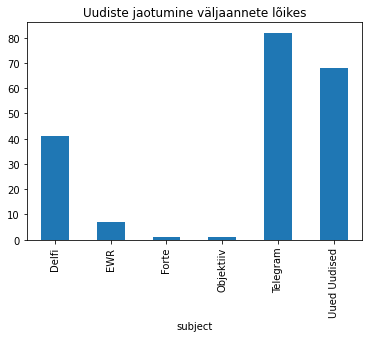

In [48]:
# Uudised väljaannete lõikes
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.title("Uudiste jaotumine väljaannete lõikes")
plt.show()

target
fake    100
true    100
Name: text, dtype: int64


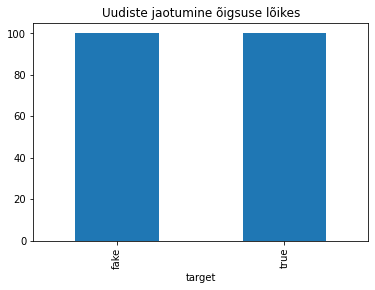

In [34]:
# Uudised info õigsuse lõikes
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.title("Uudiste jaotumine õigsuse lõikes")
plt.show()

In [11]:
fake_data = data[data["target"] == "fake"]
real_data = data[data["target"] == "true"]

# Sõnapilved
## Nimi- ja omadussõnade kasutamine

EstNLTK vahenditega vaadeldakse uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


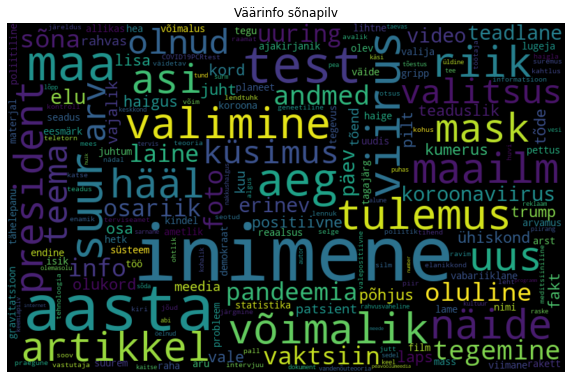

In [12]:
# Väärinfo sõnapilv
fake_sonad = []
for i in tqdm(range (0, len(fake_data))):
    rida = fake_data.iloc[i]
    tekst = Text(rida[0]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            fake_sonad.append(sona[0][0])

all_words = ' '.join(map(str, fake_sonad))


wordcloud = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Väärinfo sõnapilv")
plt.show()

In [15]:
df_1 =pd.DataFrame(fake_sonad, columns=['sõna'])
sagedused_1 = df_1.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_1['osakaal %']= (sagedused_1['esinemissagedus']/len(fake_sonad)*100)

In [35]:
print("Väärinfo nimisõnade ja omadussõnade TOP 10")
sagedused_1

Väärinfo nimisõnade ja omadussõnade TOP 10


,sõna,esinemissagedus,osakaal %
1260,inimene,349,1.670816
71,aasta,233,1.115473
4604,test,131,0.627154
2554,maa,129,0.617579
4242,suur,111,0.531406
5309,viirus,111,0.531406
103,aeg,108,0.517043
5114,valimine,94,0.450019
5446,võimalik,92,0.440444
4745,tulemus,92,0.440444


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.16it/s]


(-0.5, 799.5, 499.5, -0.5)

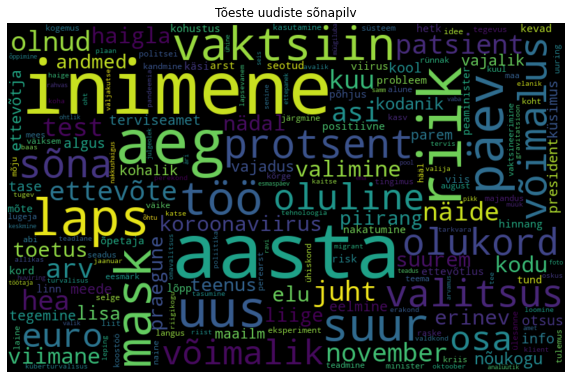

In [17]:
# Tõeste uudiste sõnapilv
real_sonad = []
for i in tqdm(range (0, len(real_data))):
    rida = real_data.iloc[i]
    tekst = Text(rida[0]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            real_sonad.append(sona[0][0])

all_words = ' '.join(map(str, real_sonad))

wordcloud = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Tõeste uudiste sõnapilv")
plt.axis("off")

In [18]:
df_2 =pd.DataFrame(real_sonad, columns=['sõna'])
sagedused_2 = df_2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_2['osakaal %']= (sagedused_2['esinemissagedus']/len(real_sonad)*100)

In [19]:
print("Tõeste uudiste nimisõnade ja omadussõnade TOP 10")
sagedused_2

Tõeste uudiste nimisõnade ja omadussõnade TOP 10


,sõna,esinemissagedus,osakaal %
40,aasta,197,1.482764
833,inimene,181,1.362336
63,aeg,119,0.895680
2822,riik,110,0.827939
2606,päev,77,0.579557
3722,uus,76,0.572031
1645,laps,76,0.572031
1913,mask,74,0.556977
3631,töö,64,0.481710
3764,vaktsiin,64,0.481710


In [20]:
print("Väärinfo sõnade listis nimisõnu ja omadussõnu:", len(fake_sonad))
print("Tõese info sõnade listis nimisõnu ja omadussõnu: ", len(real_sonad))
print("Väärinfo andmed: ", fake_data.shape)
print("Tõene info andmed: ", real_data.shape)

Väärinfo sõnade listis nimisõnu ja omadussõnu: 20888
Tõese info sõnade listis nimisõnu ja omadussõnu:  13286
Väärinfo andmed:  (100, 4)
Tõene info andmed:  (100, 4)


In [21]:
fake_sonad_stop = []
for sona in fake_sonad:
    if sona not in stopsõnad_uus:
        fake_sonad_stop.append(sona)
real_sonad_stop = []
for sona in real_sonad:
    if sona not in stopsõnad_uus:
        real_sonad_stop.append(sona)

In [22]:
len(fake_sonad_stop)

20736

In [23]:
len(real_sonad_stop)

13205

In [24]:
fake_data_sonad = pd.DataFrame(fake_sonad_stop)
real_data_sonad = pd.DataFrame(real_sonad_stop)

In [25]:
sonakaupa_fake = fake_data_sonad[0].value_counts().to_frame()
sonakaupa_fake.reset_index(inplace=True)
# Väärinfo sõnade sagedused
sonakaupa_fake = sonakaupa_fake.rename(columns = {'index':'lemma',0:'sagedus'})
# Väärinfo sõnade hulk
sagedased_fake = sonakaupa_fake['lemma'].tolist()

In [26]:
sonakaupa_real= real_data_sonad[0].value_counts().to_frame()
sonakaupa_real.reset_index(inplace=True)
# Tõese info sõnade sagedused
sonakaupa_real = sonakaupa_real.rename(columns = {'index':'lemma',0:'sagedus'})
# Tõese info sõnade hulk
sagedased_real = sonakaupa_real['lemma'].tolist()

Text(0.5, 1.0, 'Väärinfo sõnade sageduste TOP10')

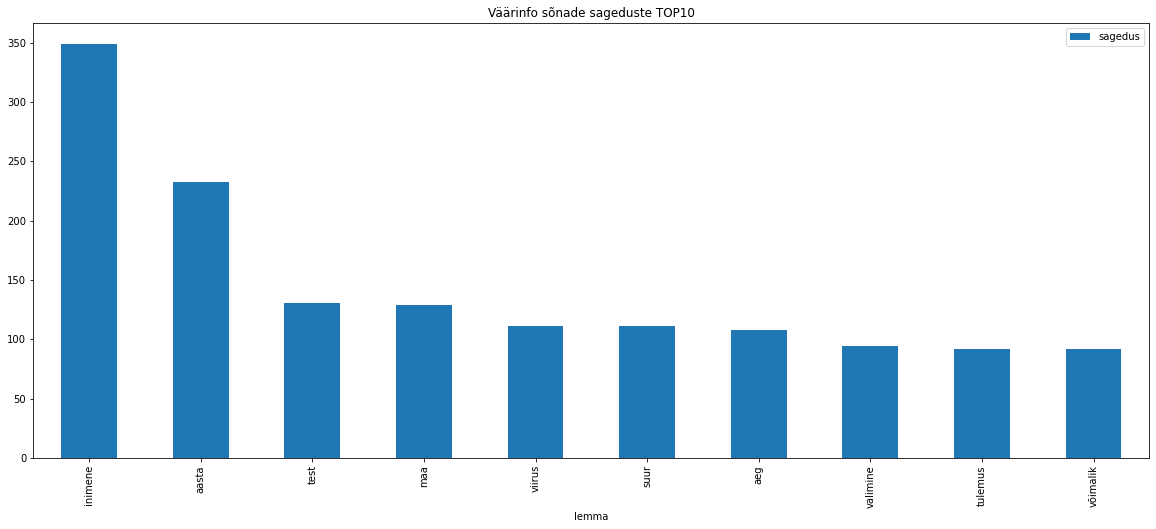

In [37]:
sonakaupa_fake[:10].plot(kind='bar', x='lemma', y='sagedus', figsize=(20,8))
plt.title("Väärinfo sõnade sageduste TOP10")

Text(0.5, 1.0, 'Tõese info sõnade sageduste TOP10')

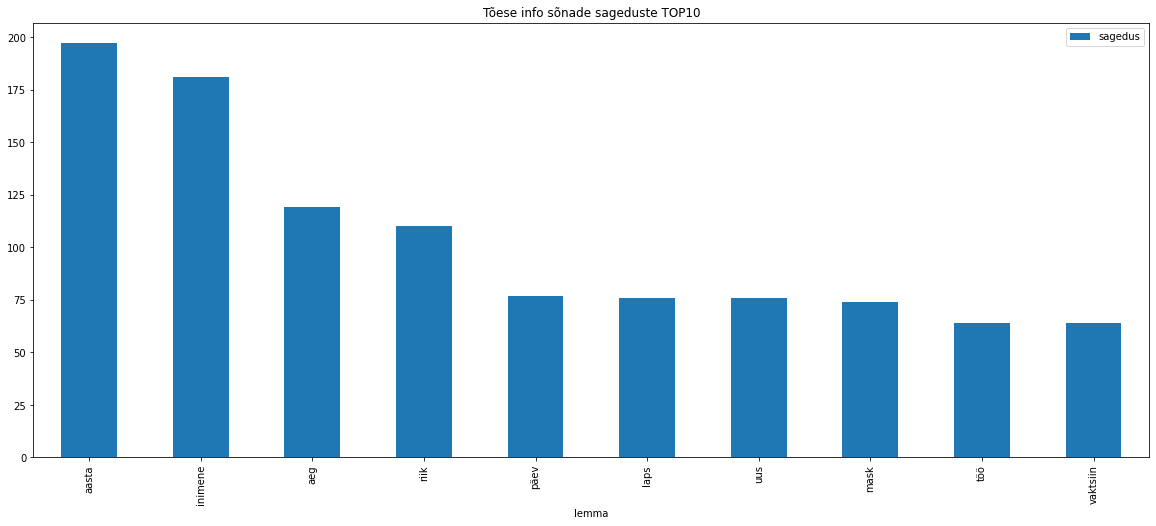

In [39]:
sonakaupa_real[:10].plot(kind='bar', x='lemma', y='sagedus', figsize=(20,8))
plt.title("Tõese info sõnade sageduste TOP10")

In [30]:
#Wordnet on leksikaal-semantiline andmebaas,
#mis sisaldab informatsiooni mõistete ja nendevaheliste semantiliste suhete kohta. 

#Wordneti tüüpi tesauruse põhiühik on sünonüümihulk (ka sünohulk). 
#See koosneb kõigist ühte ja sama mõistet väljendavatest sõnadest (või sõnaühenditest). 
#Kõik sünohulga liikmed on ühest sõnaliigist. Kõige lihtsamal juhtumil sisaldab sünohulk ainult ühe sõna, 
#siis ei ole sõnal ühtegi sünonüümi (antud mõistet saab väljendada ainult ühe sõnaga).

#Sünohulgad on on ühendatud viidetega, mis vastavad mõistetevahelistele semantilistele või leksikaalsetele suhetele.
#https://www.cl.ut.ee/ressursid/teksaurus/?lang=et

def wordnet(sagedased, pealkiri):
    wn = Wordnet()
    syno = []
    for sona in sagedased[:10]:
        syno.append(wn[sona])
    syno_1 = []
    for sage1 in syno:
        #print(sage1)
        for s in sage1:
            syno_1.append(s)

    mudeli_kaugused = {}

    for sage1 in tqdm(syno_1):
        match1 = re.search(r'\d{2}', str(sage1))
        sisemine_dct = {}
        for sage2 in syno_1:
            match2 = re.search(r'\d{2}', str(sage2))
            if sage1 != sage2:
                sisemine_dct[sage2.lemmas[0]+'_'+match2[0]] = wn.path_similarity(sage1, sage2)
        mudeli_kaugused[sage1.lemmas[0]+'_'+match1[0]] =sisemine_dct
    kaugused = pd.DataFrame.from_dict(mudeli_kaugused)
    plt.subplots(figsize=(10,5))
    plt.title(pealkiri)
    return sns.heatmap(kaugused)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [06:09<00:00, 10.56s/it]


<AxesSubplot:title={'center':'Väärinfo sõnade sünohulkade vahelised kaugused'}>

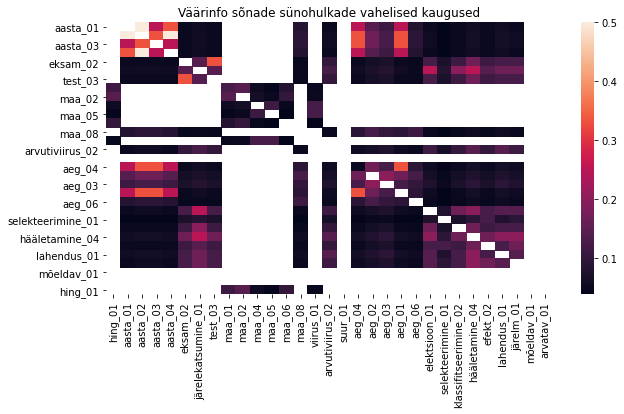

In [31]:
#10 esimest sagedasemat sõna
wordnet(sagedased_fake, "Väärinfo sõnade sünohulkade vahelised kaugused")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [08:42<00:00, 13.06s/it]


<AxesSubplot:title={'center':'Tõese info sõnade sünohulkade vahelised kaugused'}>

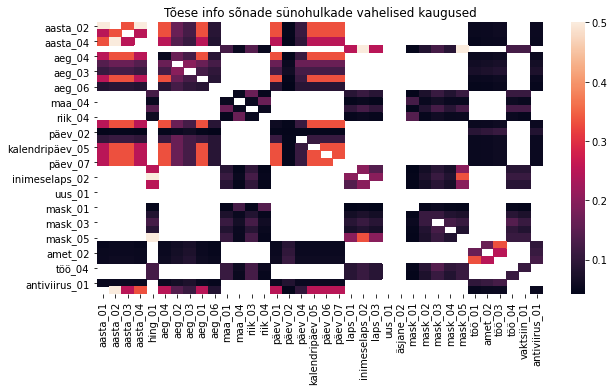

In [32]:
#10 esimest sagedasemat sõna
wordnet(sagedased_real, "Tõese info sõnade sünohulkade vahelised kaugused")

In [71]:
#Word2vec'i (W2V) mudel põhineb distributiivsushüpoteesil: sarnase distributsiooniga lingvistilised 
#üksused on ka semantiliselt sarnased. Teisisõnu, sarnastes kontekstides esinevad sõnad on sarnase tähendusega. 

def word2vec(data, sagedased, pealkiri):
    data_string = data_copy['text'].to_string() 
    tekst2 = Text(data_string).tag_layer()
    korpus = []
    for lause in tekst2.sentences:
        anekd = []
        for sona in lause:
            if len(sona.text) != 1:
                if sona.text != '...':
                    #print(sona.lemma[0])
                    anekd.append(sona.lemma[0])
        korpus.append(anekd)
    korpus = [[string for string in sublist] for sublist in korpus]   
    #korpus = [[string.lower() for string in sublist] for sublist in korpus]
    #mudeli treenimine
    mudel = Word2Vec(korpus, min_count = 1)
    
    mudeli_kaugused = {}
    for sage1 in tqdm(sagedased[:50]):
        sisemine_dct = {}
        for sage2 in sagedased[:50]:
            if sage1 != sage2:
                #print(sage1, sage2, mudel_fake.wv.similarity(sage1, sage2))
                sisemine_dct[sage2] = mudel.wv.similarity(sage1, sage2)
        mudeli_kaugused[sage1] =sisemine_dct
    tabel = pd.DataFrame.from_dict(mudeli_kaugused)
    plt.subplots(figsize=(15,10))
    plt.title(pealkiri)
    return sns.heatmap(tabel)

INFO:word2vec.py:1399: collecting all words and their counts
INFO:word2vec.py:1384: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:word2vec.py:1407: collected 5609 word types from a corpus of 25600 raw words and 1876 sentences
INFO:word2vec.py:1458: Loading a fresh vocabulary
INFO:word2vec.py:1482: effective_min_count=1 retains 5609 unique words (100% of original 5609, drops 0)
INFO:word2vec.py:1488: effective_min_count=1 leaves 25600 word corpus (100% of original 25600, drops 0)
INFO:word2vec.py:1547: deleting the raw counts dictionary of 5609 items
INFO:word2vec.py:1550: sample=0.001 downsamples 36 most-common words
INFO:word2vec.py:1553: downsampling leaves estimated 21157 word corpus (82.6% of prior 25600)
INFO:base_any2vec.py:1008: estimated required memory for 5609 words and 100 dimensions: 7291700 bytes
INFO:word2vec.py:1699: resetting layer weights


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1354.50it/s]

INFO:base_any2vec.py:1196: training model with 3 workers on 5609 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 2 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 1 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 0 more threads
INFO:base_any2vec.py:1332: EPOCH - 1 : training on 25600 raw words (21201 effective words) took 0.0s, 948952 effective words/s
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 2 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 1 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 0 more threads
INFO:base_any2vec.py:1332: EPOCH - 2 : training on 25600 raw words (21065 effective words) took 0.0s, 1178692 effective words/s
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 2 more threads
INFO:base_any2

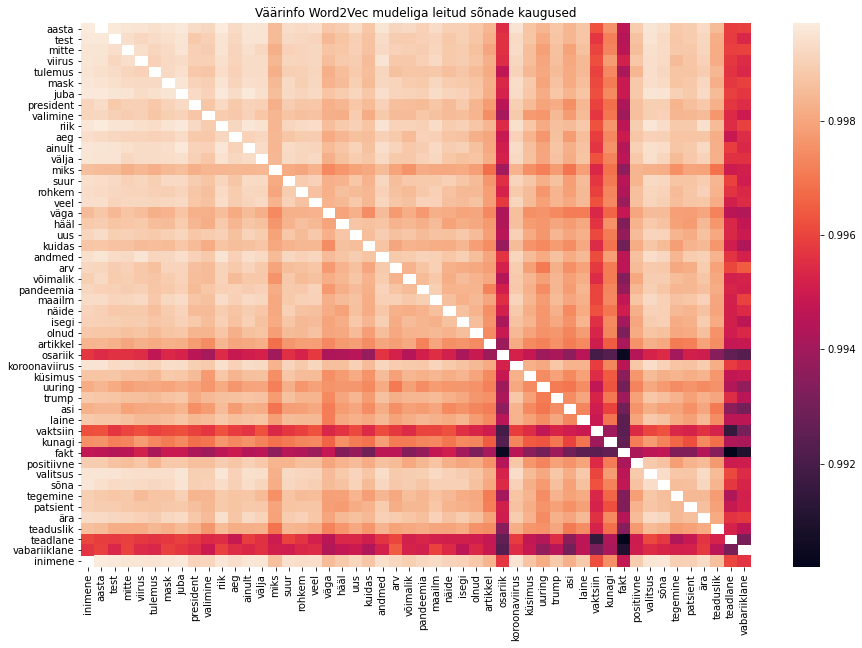

In [220]:
mudel_fake = word2vec(fake, sagedased_fake, "Väärinfo Word2Vec mudeliga leitud sõnade kaugused")

INFO:word2vec.py:1399: collecting all words and their counts
INFO:word2vec.py:1384: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:word2vec.py:1407: collected 5609 word types from a corpus of 25600 raw words and 1876 sentences
INFO:word2vec.py:1458: Loading a fresh vocabulary
INFO:word2vec.py:1482: effective_min_count=1 retains 5609 unique words (100% of original 5609, drops 0)
INFO:word2vec.py:1488: effective_min_count=1 leaves 25600 word corpus (100% of original 25600, drops 0)
INFO:word2vec.py:1547: deleting the raw counts dictionary of 5609 items
INFO:word2vec.py:1550: sample=0.001 downsamples 36 most-common words
INFO:word2vec.py:1553: downsampling leaves estimated 21157 word corpus (82.6% of prior 25600)
INFO:base_any2vec.py:1008: estimated required memory for 5609 words and 100 dimensions: 7291700 bytes
INFO:word2vec.py:1699: resetting layer weights


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1319.33it/s]

INFO:base_any2vec.py:1196: training model with 3 workers on 5609 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 2 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 1 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 0 more threads
INFO:base_any2vec.py:1332: EPOCH - 1 : training on 25600 raw words (21201 effective words) took 0.0s, 851394 effective words/s
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 2 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 1 more threads
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 0 more threads
INFO:base_any2vec.py:1332: EPOCH - 2 : training on 25600 raw words (21065 effective words) took 0.0s, 837488 effective words/s
INFO:base_any2vec.py:348: worker thread finished; awaiting finish of 2 more threads
INFO:base_any2v

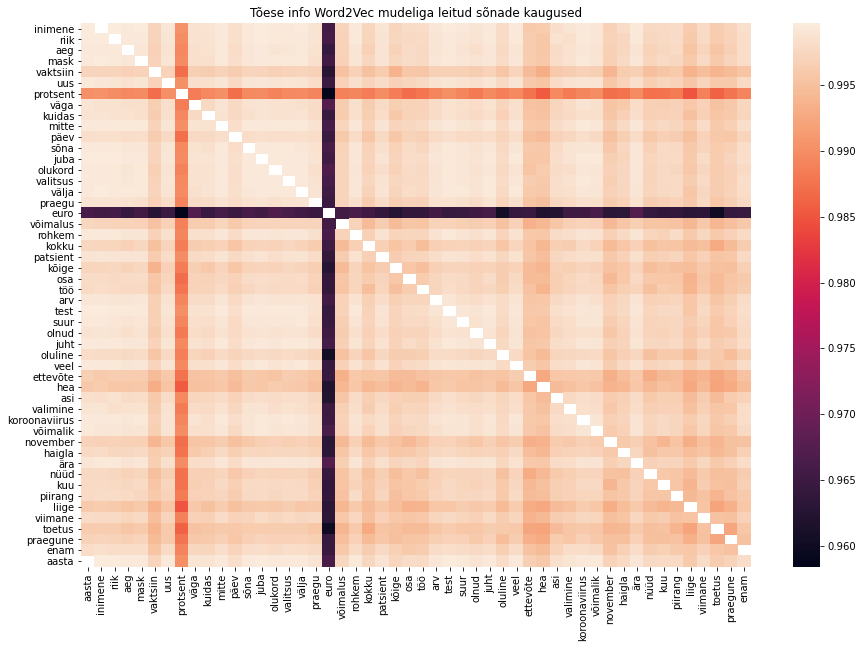

In [221]:
mudel_true = word2vec(true, sagedased_real, "Tõese info Word2Vec mudeliga leitud sõnade kaugused")